In [ ]:
#@title Allowed Resources
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 2
RAM GB: 12.7
PyTorch version: 1.10.0+cu111
CUDA version: 11.1
cuDNN version: 8005
device: cuda
Sat Feb  5 10:28:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------

## Install requirements

In [ ]:
%%capture
!pip install ruclip==0.0.1 > /dev/null
!pip install git+https://github.com/cene555/ruCLIP-SB.git
!pip install pymorphy2
!gdown -O ruCLIP-SB.pkl https://drive.google.com/uc?id=1-CghuC9TCIDyn5H3zQS6ho_TNiudzJCX
!gdown -O cifar100classes.json https://drive.google.com/uc?id=1ZJhOp5RP5wY31TyJgGNXa9xaJO8SdAhf

## Import libraries

In [ ]:
import os
import torch
import ruclip
import random
import numpy as np
import skimage
from glob import glob
from tqdm.auto import tqdm
from torchvision.datasets import CIFAR100
from torchvision import transforms
import transformers
from transformers import BertTokenizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from ruclipsb import ruCLIPSB
from ruclipsb.utils import tokenize, _convert_image_to_rgb
import base64
from io import BytesIO
import requests
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageCms
import cv2
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
torch.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Load RuCLIP model

In [ ]:
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)

Downloading:   0%|          | 0.00/748k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/606M [00:00<?, ?B/s]

## Load RuCLIP-SB model

In [ ]:
model = ruCLIPSB()
model.load_state_dict(torch.load('ruCLIP-SB.pkl', map_location=device))
model = model.half().to(device)

model = model.eval()
for x in model.parameters(): x.requires_grad = False
torch.cuda.empty_cache()

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_tiny_patch4_window7_224.pth


Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/45.5M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny")

Downloading:   0%|          | 0.00/235k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/457k [00:00<?, ?B/s]

In [ ]:
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            _convert_image_to_rgb,
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),])

# Calculating cosine similarity

### RuCLIP cosine similarity

In [ ]:
def show_similarity_ruClip(descriptions):
    templates = ['{}', 'это {}']
    predictor = ruclip.Predictor(clip, processor, device, bs=8, templates=templates)

    classes = list(descriptions.values())
    url = 'https://raw.githubusercontent.com/comptech-winter-school/image-finder/main/assets/'
    
    pil_images = []
    for image_name in descriptions:
        page = requests.get(url + image_name)
        pil_images.append(Image.open(BytesIO(page.content)))


    with torch.no_grad():
        text_latents = predictor.get_text_latents(classes)
        image_latents = predictor.get_image_latents(pil_images)
        logits_per_text = torch.matmul(text_latents, image_latents.t())
        logits_per_image = logits_per_text.t()

    count = len(classes)
    similarity = logits_per_image.cpu().numpy()

    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    plt.yticks(range(count), classes, fontsize=18)
    plt.xticks([])

    for i, pil_img in enumerate(pil_images):
        plt.imshow(pil_img, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')

    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f'{similarity[y, x]:.2f}', ha='center', va='center', size=12)

    for side in ['left', 'top', 'right', 'bottom']:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])
    plt.title('Cosine similarity between text and image features RuCLIP', size=20)

### RuCLIP-SB cosine similarity

In [ ]:
# @title Define show_test_images function

import json
import os
import skimage
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor


def test_images_ruClipSB(descriptions):
    input_resolution = 224
    preprocess = Compose([
        Resize(input_resolution, interpolation=Image.BICUBIC),
        CenterCrop(input_resolution),
        ToTensor()
    ])

    images = []
    texts = []
    img_paths = []
    url = 'https://raw.githubusercontent.com/comptech-winter-school/image-finder/main/assets/'

    for filename in [image_name for image_name in descriptions]:
        page = requests.get(url + filename)
        fn = BytesIO(page.content)
        image = preprocess(Image.open(fn).convert('RGB'))
        images.append(url + filename)
        texts.append(descriptions[filename])

    return images, texts

In [ ]:
# @title Define show_similarity function

def show_similarity_ruClipSB(images, texts, similarity):
    input_resolution = 224
    preprocess = Compose([
        Resize(input_resolution, interpolation=Image.BICUBIC),
        CenterCrop(input_resolution),
        ToTensor()
    ])
    count = len(texts)

    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    plt.yticks(range(count), texts, fontsize=18)
    plt.xticks([])
    for i, image in enumerate(images):
        if isinstance(image, str):
            page = requests.get(image)
            image = BytesIO(page.content)
            image = Image.open(image)
            image = preprocess(image.convert('RGB'))
        plt.imshow(image.permute(1, 2, 0), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')
    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f'{similarity[y, x]:.2f}', ha='center', va='center', size=12)

    for side in ['left', 'top', 'right', 'bottom']:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])

    plt.title('Cosine similarity between text and image features RuCLIP-SB', size=20)

### Show cosine similarity RuCLIP vs RuCLIP-SB

8it [00:00, 20.98it/s]


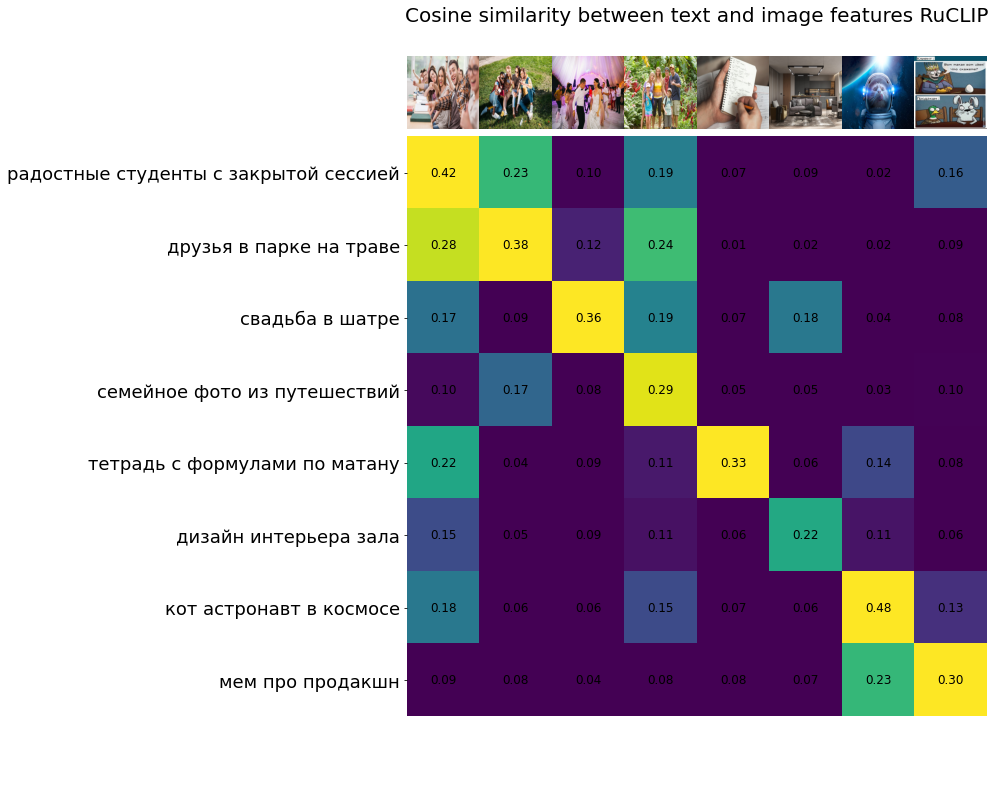

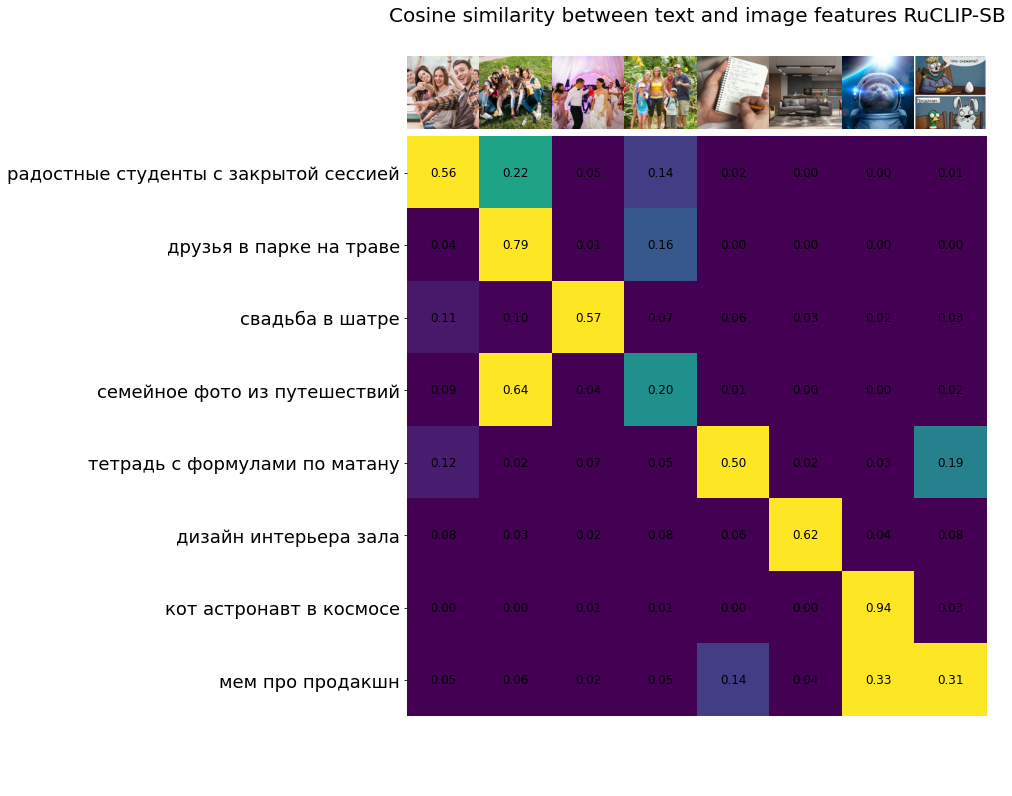

In [ ]:
import urllib.request

studies = 'радостные студенты с закрытой сессией'
everyday = 'друзья в парке на траве'
wedding = 'свадьба в шатре'
tavel = 'семейное фото из путешествий'
formulas = 'тетрадь с формулами по матану'
design = 'дизайн интерьера зала'
astronaut_cat = 'кот астронавт в космосе'
mem = 'мем про продакшн'

descriptions = {
    'studies.jpg': studies,
    'everyday.jpg': everyday,
    'wedding.jpg': wedding,
    'tavel.jpg': tavel,
    'formulas.jpg': formulas,
    'design.jpg': design,
    'astronaut_cat.jpg': astronaut_cat,
    'mem.png': mem
}

show_similarity_ruClip(descriptions)

images, texts = test_images_ruClipSB(descriptions)

images_test = []




for i in images:
    with urllib.request.urlopen(i) as url:
        req = url.read()
    arr = np.asarray(bytearray(req), dtype=np.uint8)
    img = cv2.imdecode(arr, -1) 
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    images_test.append(transform(image))
images_test = torch.stack(images_test, axis=0).to(device)

with torch.inference_mode():
    text_tokens, attention_mask = tokenize(tokenizer, texts, 77)
    text_tokens, attention_mask = text_tokens.to(device), attention_mask.to(device)
    text_features = model.encode_text(text_tokens, attention_mask).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    image_features = model.encode_image(images_test).float()
    text_probs = (1 * image_features @ text_features.T).softmax(dim=-1)

similarity = text_probs.cpu().numpy()
_ = show_similarity_ruClipSB(images, texts, similarity)

# Accuracy RuCLIP vs RuCLIP-SB (CIFAR100)

### RuCLIP prediction

In [ ]:
classes = ['яблоко', 'аквариумные рыбки', 'младенец', 'медведь', 'бобр', 'кровать', 'пчела', 'жук', 'велосипед', 'бутылка', 'чаша', 'мальчик', 'мост', 'автобус', 'бабочка', 'верблюд', 'мочь', 'замок', 'гусеница', 'крупный рогатый скот', 'стул', 'шимпанзе', 'часы', 'облако', 'таракан', 'диван', 'краб', 'крокодил', 'чашка', 'динозавр', 'дельфин', 'слон', 'камбала', 'лес', 'лиса', 'девочка', 'хомяк', 'дом', 'кенгуру', 'клавиатура', 'лампа', 'газонокосилка', 'леопард', 'лев', 'ящерица', 'лобстер', 'мужчина', 'кленовое дерево', 'мотоцикл', 'гора', 'мышь', 'гриб', 'дубовое дерево', 'оранжевый', 'орхидея', 'выдра', 'пальма', 'груша', 'пикап', 'сосна', 'простой', 'тарелка', 'мак', 'дикобраз', 'опоссум', 'кролик', 'енот', 'луч', 'дорога', 'ракета', 'роза', 'море', 'печать', 'акула', 'землеройка', 'скунс', 'небоскреб', 'улитка', 'змея', 'паук', 'белка', 'трамвай', 'подсолнух', 'сладкий перец', 'стол', 'бак', 'телефон', 'телевидение', 'тигр', 'трактор', 'поезд', 'форель', 'тюльпан', 'черепаха', 'гардероб', 'кит', 'ива', 'волк', 'женщина', 'червь']
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [ ]:
predictor = ruclip.Predictor(clip, processor, device, bs=16, templates=None)

In [ ]:
with torch.no_grad():
    text_latents = predictor.get_text_latents(classes)
    images = (pil_img for pil_img, _ in cifar100)
    image_latents = predictor.get_image_latents(images)
    logits_per_text = torch.matmul(text_latents, image_latents.t())
    logits_per_image = logits_per_text.t()
    ru_clip_probs = logits_per_image.cpu().numpy()

10000it [01:52, 88.72it/s]


In [ ]:
def get_topk_accuracy(labels, probs, k=5):
    successes = 0
    for lbl, p in zip(labels, np.array(probs)):
        _, top_labels = torch.tensor(p).topk(k, dim=-1)
        if lbl in top_labels:
            successes += 1
    return successes / len(labels)

In [ ]:
ru_clip_acc = get_topk_accuracy(cifar100.targets, ru_clip_probs, k=1)
print("RuCLIP accuracy =", ru_clip_acc)

RuCLIP accuracy = 0.5288


In [ ]:
ru_clip_5acc = get_topk_accuracy(cifar100.targets, ru_clip_probs, k=5)
print("RuCLIP top-5 accuracy =", ru_clip_5acc)

RuCLIP top-5 accuracy = 0.7602


In [ ]:
ru_clip_pred = []
for prob in ru_clip_probs:
    ru_clip_pred.append(np.argmax(prob))


### RuCLIP-SB prediction

In [ ]:
from torchvision.datasets import CIFAR100
import os
import json
from tqdm.auto import tqdm
import torch
from pymorphy2 import MorphAnalyzer


def prepare_classes(classes, ma=MorphAnalyzer()):
    res = []
    '''
    for cls in classes:
        cls = ma.parse(cls)[0].inflect({"gent"}).word
        res.append(cls)
    '''
    return [f"{label.lower()}" for label in classes]


def get_text_probs_from_dataset(
        model,
        tokenizer=None,
        ds=None,
        train=False,
        classes_path=None,
        text_descriptions=None,
        transform=None
):
    if ds is None:
        cls = CIFAR100
        ds = cls(os.path.expanduser("~/.cache"), download=True, train=train)
        if classes_path is None:
            classes_path = f"../clip/evaluate/{name.lower()}/{name.lower()}classes.json"
        with open(classes_path, "r") as file:
            ds.classes = json.load(file)
    if text_descriptions is None:
        text_descriptions = prepare_classes(ds.classes)
    input_ids, attention_mask = tokenize(tokenizer, text_descriptions, 77)
    probs = []
    labels = []
    with torch.no_grad():
        text_features = model.encode_text(input_ids.to(device), attention_mask.to(device)).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)
        for x in tqdm(ds, total=len(ds)):
            images = [transform(x[0])]
            image_features = model.encode_image(torch.stack(images).to(device)).float()
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_probs = (1 * image_features @ text_features.T).softmax(dim=-1)
            labels.append(x[1])
            probs.append(text_probs.tolist()[0])
    return probs, labels

In [ ]:
ru_clip_sb_probs, labels = get_text_probs_from_dataset(model, tokenizer, classes_path="cifar100classes.json", transform=transform)

Files already downloaded and verified


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
ru_clip_sb_acc = get_topk_accuracy(cifar100.targets, ru_clip_sb_probs, k=1)
print("RuCLIP-SB accuracy =", ru_clip_sb_acc)

RuCLIP-SB accuracy = 0.3698


In [ ]:
ru_clip_sb_5acc = get_topk_accuracy(cifar100.targets, ru_clip_sb_probs, k=5)
print("RuCLIP-SB top-5 accuracy =", ru_clip_sb_5acc)

RuCLIP-SB top-5 accuracy = 0.6323


In [ ]:
ru_clip_sb_pred = []
for prob in ru_clip_sb_probs:
    ru_clip_sb_pred.append(np.argmax(prob))

### Precision and Recall RuCLIP vs RuCLIP-SB

In [ ]:
print(classification_report(np.array(cifar100.targets), np.array(ru_clip_pred), target_names=classes))
print(classification_report(np.array(cifar100.targets), np.array(ru_clip_sb_pred), target_names=classes))

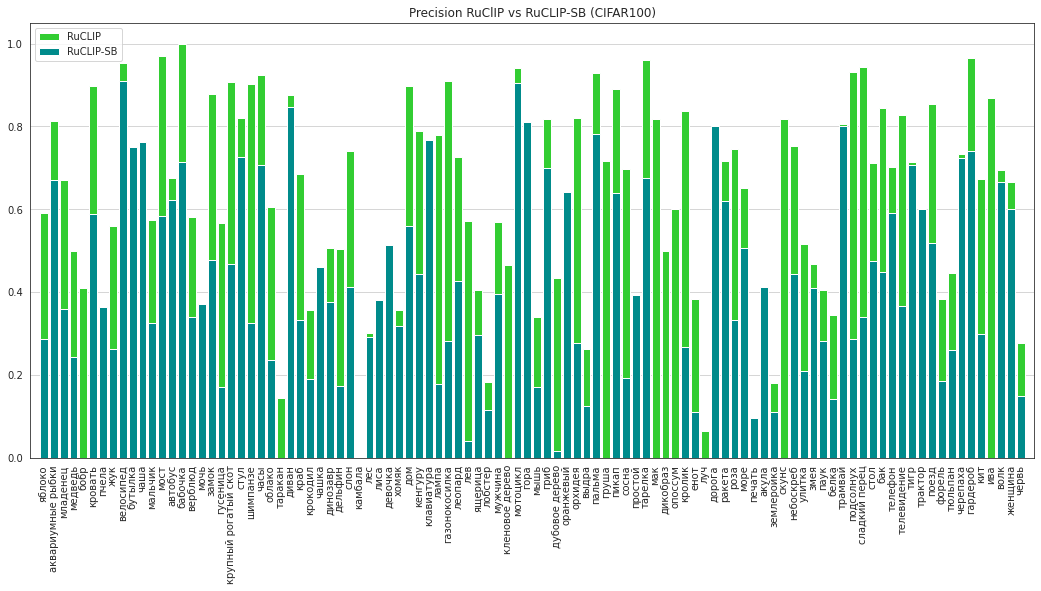

In [ ]:
from sklearn.metrics import precision_score
import seaborn as sns

ru_clip_precision = precision_score(np.array(cifar100.targets), np.array(ru_clip_pred), average=None)
ru_clip_sb_precision = precision_score(np.array(cifar100.targets), np.array(ru_clip_sb_pred), average=None)

sns.set_style("white")
plt.figure(figsize=(18, 8))
plt.grid(axis='y',zorder=0)
plt.margins(x=0.01)
plt.bar(classes, ru_clip_precision, color='#32CD32', align='center', zorder=3, label='RuCLIP')
plt.bar(classes, ru_clip_sb_precision, color='#008B8B', align='center', zorder=3, label='RuCLIP-SB')

plt.title('Precision RuClIP vs RuCLIP-SB (CIFAR100)')
plt.legend(loc='best')

plt.xticks(rotation='vertical')
plt.show()

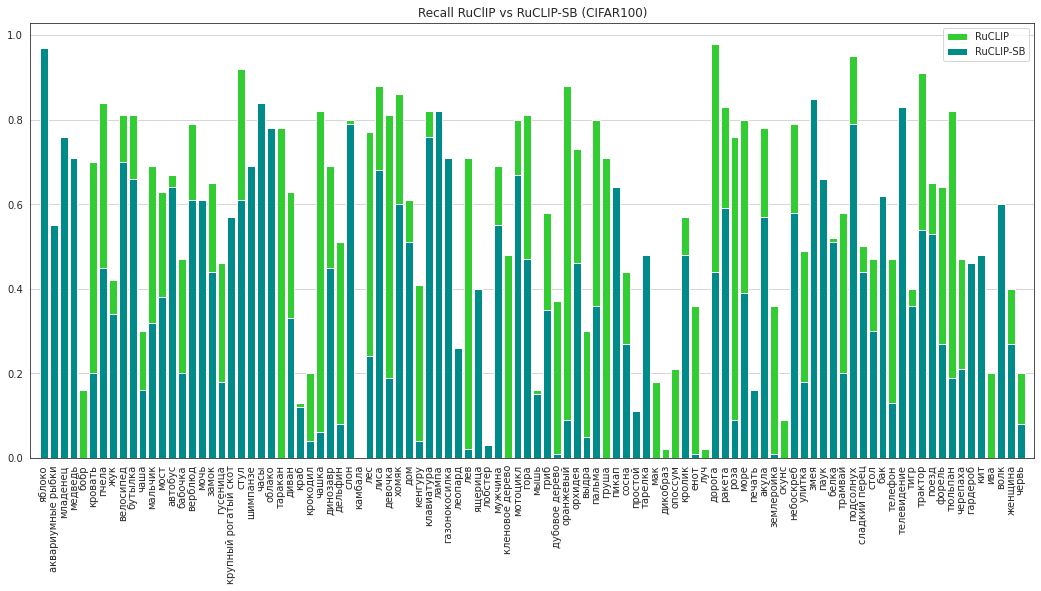

In [ ]:
from sklearn.metrics import recall_score
import seaborn as sns

ru_clip_recall = recall_score(np.array(cifar100.targets), ru_clip_pred, average=None)
ru_clip_sb_recall = recall_score(np.array(cifar100.targets), ru_clip_sb_pred, average=None)

sns.set_style("white")
plt.figure(figsize=(18, 8))
plt.grid(axis='y',zorder=0)
plt.margins(x=0.01)
plt.bar(classes, ru_clip_recall, color='#32CD32', align='center', zorder=3, label='RuCLIP')
plt.bar(classes, ru_clip_sb_recall, color='#008B8B', align='center', zorder=3, label='RuCLIP-SB')

plt.title('Recall RuClIP vs RuCLIP-SB (CIFAR100)')
plt.legend(loc='best')

plt.xticks(rotation='vertical')
plt.show()

## Accuracy&Top-5 accuracy

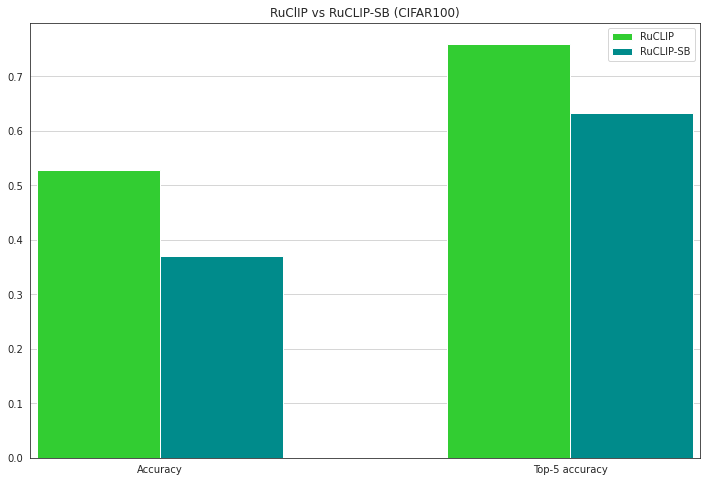

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.3
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
ru_clip = [ru_clip_acc, ru_clip_5acc]
ru_clip_sb = [ru_clip_sb_acc, ru_clip_sb_5acc]

# Set position of bar on X axis
br1 = np.arange(len(ru_clip))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, ru_clip, color ='#32CD32', width = barWidth,
        edgecolor ='white', label ='RuCLIP')
plt.bar(br2, ru_clip_sb, color ='#008B8B', width = barWidth,
        edgecolor ='white', label ='RuCLIP-SB')
 
# Adding Xticks
plt.xlabel('', fontweight ='bold', fontsize = 15)
plt.ylabel('', fontweight ='bold', fontsize = 15)
plt.xticks([r + 0.15 for r in range(len(ru_clip))], ['Accuracy', 'Top-5 accuracy'])
plt.grid(axis='y',zorder=0)
plt.margins(x=0.01)
plt.title('RuClIP vs RuCLIP-SB (CIFAR100)')
 
plt.legend()
plt.show()

# RuCLIP inference

In [1]:
%%capture
!pip install git+https://github.com/Lednik7/CLIP-ONNX.git
!pip install ruclip==0.0.1rc7
!pip install onnxruntime-gpu

In [2]:
%%capture
!wget -c -O CLIP.png https://github.com/openai/CLIP/blob/main/CLIP.png?raw=true

In [3]:
import onnxruntime

# priority device (if available)
print(onnxruntime.get_device())

GPU


In [4]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
import ruclip

# onnx cannot export with cuda
model, processor = ruclip.load("ruclip-vit-base-patch32-384", device="cpu")
predictor = ruclip.Predictor(model, processor, device="cpu", bs=16, templates=None)

Downloading:   0%|          | 0.00/748k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/606M [00:00<?, ?B/s]

In [6]:
from PIL import Image
import numpy as np

# simple input
pil_images = [Image.open("CLIP.png")]
labels = ['очень длинное предложение с глубоким смыслом и интересным сюжетом']
dummy_input = processor(text=labels, images=pil_images,
                        return_tensors='pt', padding=True)

# batch first
image = dummy_input["pixel_values"] # torch tensor [1, 3, 384, 384]
image_onnx = dummy_input["pixel_values"].cpu().detach().numpy().astype(np.float32)

# batch first
text = dummy_input["input_ids"] # torch tensor [3, 77]
text_onnx = dummy_input["input_ids"].cpu().detach().numpy()[::-1].astype(np.int64)

### Convert RuCLIP model to ONNX

In [7]:
from clip_onnx import clip_onnx

visual_path = "clip_visual.onnx"
textual_path = "clip_textual.onnx"

onnx_model = clip_onnx(model, visual_path=visual_path, textual_path=textual_path)
onnx_model.convert2onnx(image, text, verbose=True)

[CLIP ONNX] Start convert visual model
[CLIP ONNX] Start check visual model
[CLIP ONNX] Start convert textual model
[CLIP ONNX] Start check textual model
[CLIP ONNX] Models converts successfully


### CPU inference mode

In [35]:
import onnxruntime as rt

!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.158
BogoMIPS:            4400.31
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [51]:
ruclip_model_name='ruclip-vit-base-patch32-384'
providers='CPUExecutionProvider'
sess_textual = rt.InferenceSession(textual_path, providers=[providers], 
                                   provider_options=[{'device_type': 'CPU_FP32'}])
input_name_text = sess_textual.get_inputs()[0].name

sess_visual = rt.InferenceSession(visual_path, providers=[providers], 
                                  provider_options=[{'device_type': 'CPU_FP32'}])
input_name_img = sess_visual.get_inputs()[0].name

ru_clip_onnx_text = %timeit -o sess_textual.run(None, {input_name_text: text_onnx}) # text representation
ru_clip_onnx_text = int(ru_clip_onnx_text.best*1000)
ru_clip_onnx_img = %timeit -o sess_visual.run(None, {input_name_img: image_onnx}) # image representation
ru_clip_onnx_img = int(ru_clip_onnx_img.best*1000)

10 loops, best of 5: 97.1 ms per loop
1 loop, best of 5: 395 ms per loop


In [52]:
ru_clip_text = %timeit -o model.encode_text(text)
ru_clip_text = int(ru_clip_text.best*1000)
ru_clip_img = %timeit -o model.encode_image(image)
ru_clip_img = int(ru_clip_img.best*1000)

10 loops, best of 5: 136 ms per loop
1 loop, best of 5: 513 ms per loop


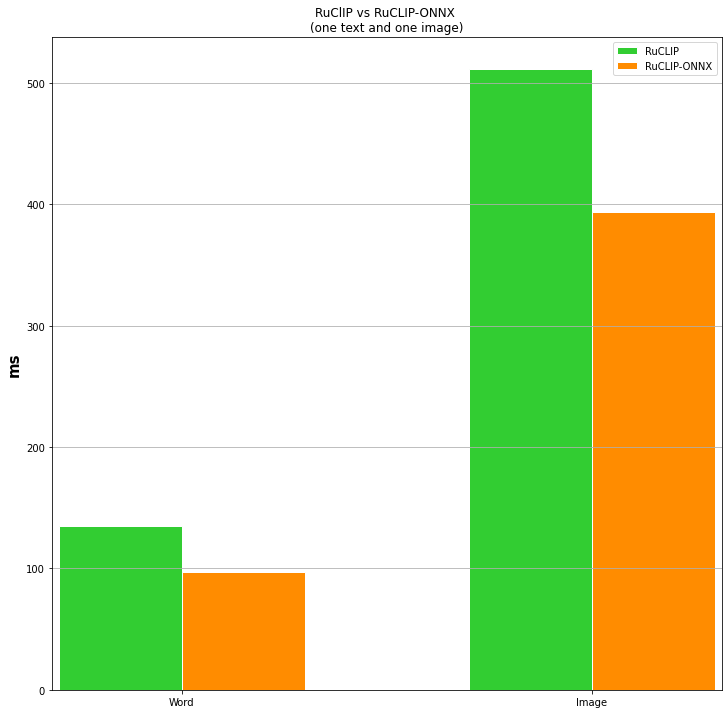

In [54]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.30
fig = plt.subplots(figsize =(12, 12))
 
# set height of bar
ru_clip = [ru_clip_text, ru_clip_img]
ru_clip_onxx = [ru_clip_onnx_text, ru_clip_onnx_img]

# Set position of bar on X axis
br1 = np.arange(len(ru_clip))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, ru_clip, color ='#32CD32', width = barWidth,
        edgecolor ='white', label ='RuCLIP')
plt.bar(br2, ru_clip_onxx, color ='#FF8C00', width = barWidth,
        edgecolor ='white', label ='RuCLIP-ONNX')

# Adding Xticks
plt.xlabel('', fontweight ='bold', fontsize = 15)
plt.ylabel('', fontweight ='bold', fontsize = 15)
plt.xticks([r + 0.15 for r in range(len(ru_clip))], ['Word', 'Image'])
plt.grid(axis='y',zorder=0, which='major')
plt.ylabel('ms', fontweight ='bold', fontsize = 15)

plt.margins(x=0.01)
plt.title('RuClIP vs RuCLIP-ONNX \n(one text and one image)')
 
plt.legend()
plt.show()